<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#UK-Parliamentary-elections" data-toc-modified-id="UK-Parliamentary-elections-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>UK Parliamentary elections</a></span></li><li><span><a href="#How-many-seats-change-hands-from-one-election-to-the-next" data-toc-modified-id="How-many-seats-change-hands-from-one-election-to-the-next-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>How many seats change hands from one election to the next</a></span><ul class="toc-item"><li><span><a href="#2010-2017-results" data-toc-modified-id="2010-2017-results-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>2010-2017 results</a></span></li><li><span><a href="#Next-steps" data-toc-modified-id="Next-steps-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Next steps</a></span></li><li><span><a href="#Update" data-toc-modified-id="Update-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Update</a></span></li></ul></li><li><span><a href="#Turnout" data-toc-modified-id="Turnout-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Turnout</a></span></li></ul></div>

## UK Parliamentary elections

The data I am using is the results of elections to the Westminster Parliament.  I start by cutting down the original data set which has all results since 1918.  Unfortunately the constituencies have changed over time and the last boundary change finished in 2010.
The metadata, in Word format, is [here](http://researchbriefings.files.parliament.uk/documents/CBP-8647/CBP-8647.docx).
Initial questions to consider are:
* Which which areas have long-time incumbent parties?  Which are more variable?
* How have the major parties fared overall over time?
* Are there differences over time in different consituencies or regions/countries?
* Can we extend region comparisons to trends since 1918 or 1945?
* What effect on regions did boundary changes have?
* Ireland became a republic in 1922.  Are the obvious reflections of this in the 1918 election?
* It is widely reported that turnout is falling.  Is this true everywhere?
* Where are the sharpest changes in turnout?  Where is most stable?

A summary and relevant links can be found [here](https://researchbriefings.parliament.uk/ResearchBriefing/Summary/CBP-8647).

**Supplementary note**
I have suspended work on this until the 2010-2019 results are released.  It seems like a poor use of time to undertake analysis until then.

In [1]:
# Ignore all warnings (including deprecation of datetime)
import warnings
warnings.filterwarnings("ignore")

# I will likely need these at some point.
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
import sklearn as sk
import statsmodels.api as sm
import datetime
import time

In [2]:
#url = 'http://researchbriefings.files.parliament.uk/documents/CBP-8647/1918-2017election_results.csv'
# This no longer exists now the new results files are out.  I have a local copy
url = '1918-2017election_results.csv'
df = pd.read_csv(url)
r, c = df.shape

In [3]:
print(df['boundary_set'].unique())

['1918-1935' '1945' '1950-1951' '1955-1970' '1974-1979' '1983-1992'
 '1997-2001' '2005' '2010-2017']


A few columns have trailing spaces in the column name.
This needs to be fixed!

In [4]:
df.columns = [x.rstrip() for x in df.columns]

## How many seats change hands from one election to the next

Now select the 2010- boundary set.

Vote share and turnout can be reconstructed so drop them.
And I don't care about seats as constituencies only have one seat in these elections.
I care even less about the boundary set, they are all in the same set.

In [5]:
recent = df[df['boundary_set'] == '2010-2017']

recent.drop(['seats','con_share','lib_share','lab_share','natSW_share',
             'oth_share','boundary_set','turnout','Unnamed: 19'],axis = 1, inplace = True)

recent.reset_index(drop = True, inplace = True)

In [6]:
print(recent.dtypes)

constituency_id     object
constituency        object
country/region      object
electorate          object
con_votes          float64
lib_votes           object
lab_votes           object
natSW_votes        float64
oth_votes          float64
total_votes         object
election            object
dtype: object


In [7]:
# Let's cast the number of votes & size of electorate to floats
recent = recent.astype({'total_votes':'float',
                        'electorate': 'float',
                        'con_votes':'float',
                        'lab_votes':'float',
                        'lib_votes':'float',
                        'natSW_votes':'float',
                        'oth_votes':'float',})

An obvious question is to consider how seats have changed over time.  What seats have gone to the same party three years running?

In [8]:
# Find the number of votes in each row and work out winners
recent['highest'] = recent.loc[:, 'con_votes':'oth_votes'].max(axis=1)
recent['winner'] = 'X'
for i in range(len(recent)):
    if recent['highest'][i] == recent['con_votes'][i]:
        recent['winner'][i] = 'C'
    elif recent['highest'][i] == recent['lib_votes'][i]:
        recent['winner'][i] = 'D'
    elif recent['highest'][i] == recent['lab_votes'][i]:
        recent['winner'][i] = 'L'
    elif recent['highest'][i] == recent['natSW_votes'][i]:
        recent['winner'][i] = 'N'
    elif recent['highest'][i] == recent['oth_votes'][i]:
        recent['winner'][i] = 'O'

In [9]:
#We don't need the highest votes any more, we can always reconstruct from the winner
recent.drop('highest',axis=1,inplace=True)

Separate out the three sets of results

In [10]:
results2010  = recent[recent['election']=='2010']
results2015  = recent[recent['election']=='2015']
results2017  = recent[recent['election']=='2017']
results2010.rename(columns={'winner':'winner2010'},inplace=True)
results2015.rename(columns={'winner':'winner2015'},inplace=True)
results2017.rename(columns={'winner':'winner2017'},inplace=True)

And now lets just look at the winners in each election.
Obviously the margin of victory matters but not for our purposes.

In [11]:
constituencies = pd.Series(recent['constituency_id'].unique())
wins2010=results2010[['constituency_id','winner2010']].sort_values(by='constituency_id')
wins2015=results2015[['constituency_id','winner2015']].sort_values(by='constituency_id')
wins2017=results2017[['constituency_id','winner2017']].sort_values(by='constituency_id')
winner2010  = wins2010['winner2010'].reset_index(drop = True)
winner2015  = wins2015['winner2015'].reset_index(drop = True)
winner2017  = wins2017['winner2017'].reset_index(drop = True)

### 2010-2017 results

Now put the results of the winners in each election back together

In [12]:
winners = pd.concat([constituencies, winner2010, winner2015, winner2017],axis=1)

And count how many seats did **not** change hands

In [13]:
safe_seats = 0
sc = 0 #Safe seats for the Conservative and Unionist Party
sd = 0 #Safe seats for the Liberal Democrats
sl = 0 #Safe seats for the Labour Party
sn = 0 #Safe seats for the Scottish National Party and Plaid Cymru
so = 0 #Safe seats for the other parties (mostly in Northern Ireland)
        # but see the metadata for more detailed information.
for i in range(len(winners)):
    if (winners['winner2010'][i] == winners['winner2015'][i]) and (winners['winner2015'][i] == winners['winner2017'][i]):
        safe_seats += 1
        if winners['winner2010'][i] == 'C':
            sc += 1
        elif winners['winner2010'][i] == 'D':
            sd += 1
        elif winners['winner2010'][i] == 'L':
            sl += 1
        elif winners['winner2010'][i] == 'N':
            sn += 1
        elif winners['winner2010'][i] == 'O':
            so += 1

In [14]:
print('Safe seats:', safe_seats)
print('Safe Conservative seats: ',sc,' (',round(sc/safe_seats*100),'%).',sep='')
print('Safe Lib Dem seats: ',sd,' (',round(sd/safe_seats*100),'%).',sep='')
print('Safe Labour seats: ',sl,' (',round(sl/safe_seats*100),'%).',sep='')
print('Safe Nationalist seats: ',sn,' (',round(sn/safe_seats*100),'%).',sep='')
print('\'Safe\' other seats: ',so,' (',round(so/safe_seats*100),'%).',sep='')

Safe seats: 502
Safe Conservative seats: 269 (54%).
Safe Lib Dem seats: 4 (1%).
Safe Labour seats: 203 (40%).
Safe Nationalist seats: 6 (1%).
'Safe' other seats: 20 (4%).


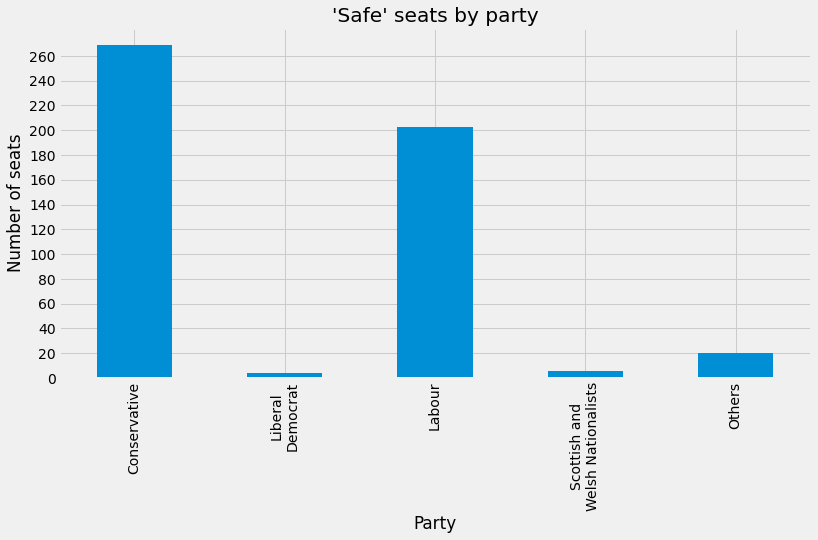

In [15]:
mpl.style.use(['fivethirtyeight']) # A good political analysis style!

safe = pd.DataFrame([sc, sd, sl, sn, so],
                   index = ['Conservative','Liberal\nDemocrat',
                            'Labour','Scottish and\nWelsh Nationalists',
                            'Others'])
ax=safe.plot(kind='bar', legend = None, figsize=(12,6))
ax.set_title('\'Safe\' seats by party')
ax.set_xlabel('Party')
ax.set_yticks(range(0,safe[0].max(),20))
ax = ax.set_ylabel('Number of seats')

54% of the safe seats are Conservative and 40% are Labour.
The low percentage of safe Lib Dem seats is a largely a result of the 2015 election.


The 'other' seats could have switched e.g. from DUP to Alliance but as these parties are 'other' this counts as the seat being maintained.
As a result the number of safe seats for the Others will be an overestimate.
Perhaps NI should be excluded from the analysis although it is only 4% of safe seats.
The Welsh and Scottish nationalist parties do not challenge each other so their 1% of safe seats is valid.

The most surprising result is that, even incuding the Liberal Democrat lack of success in 2015, only 147 seats changed hands between 2010 and 2017!

### Next steps

When the next results are released I will do a comparison with the 2019 data.  The news widely reported a huge change in the make-up of seats in the North of England, is this as big a change as the Liberal Democrat vote collapse in 2015.

After that maybe look at the largest parties regional performance since 1945 - for example there is a widespread belief that London has tended towards Labour over recent decades but that some rural areas have become more Conservative over the same period.  I suspect that the decline of the Liberal Party from 1945-1975 may complicate matters.

The claim is that the 2019 election was a huge change as the 'red wall' was breached.
How can we see whether this is true or not?
How many previously 'safe' seats changed from 2017 to 2019 and whose were they?

In [16]:
# Load new data set & clean 2019 data.
# Mark 'safe seats' in the 2017 data.
# Record L<->C but also L<->O, C<->O
# Different from previous 'teens elections?
pass

### Update
The 2019 results are out :)
https://commonslibrary.parliament.uk/research-briefings/cbp-8647/

Direct set:
http://researchbriefings.files.parliament.uk/documents/CBP-8647/1918-2019election_results-.csv

In [17]:
url = 'http://researchbriefings.files.parliament.uk/documents/CBP-8647/1918-2019election_results-.csv'
df = pd.read_csv(url, encoding='iso-8859-15')

## Turnout

In [18]:
df.shape

(17698, 19)

In [19]:
df.columns

Index(['constituency_id', 'seats', 'constituency', 'country/region',
       'electorate', 'con_votes', 'con_share', 'lib_votes ', 'lib_share',
       'lab_votes', 'lab_share', 'natSW_votes', 'natSW_share', 'oth_votes',
       'oth_share', 'total_votes', 'turnout ', 'election', 'boundary_set'],
      dtype='object')

In [20]:
df.boundary_set.unique()

array(['1918-35', '1918-45', '1945', '1950', '1955-70', '1974-79',
       '1983-92', '1997-05', '1997-01', '2005-19', '2010-19'],
      dtype=object)